# ICESat-2 data products

This tutorial is meant to show some examples of the standard land-ice data products put out by the ICESat-2 project.  It is not a comprehensive look at all the products, nor does it document all the features available in the product is shows.  Rather, it presents some tools for looking at the data, and shows how the information flows between land-ice products.

## Learning goals

1.  Demonstrate basic HDF-5 product structures of ICESat-2 standard data products 
2.  Demonstrate the flow of information from the lowest-level products to the highest-level products (or vice versa)
3.  Data search using geographic regions and file names using icePyx
4.  File-level data access from NSIDC
5.  Photon data access using SlideRule

In [66]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing

In [67]:
#Please note: This tutorial is best run in interactive mode,
# but is archived with the interactive section disabled.
# To enable interactive mode, comment the next line, and uncomment the second line:
# %matplotlib inline  
%matplotlib widget 
%config InlineBackend.figure_format = 'retina'

## 1. Location
We will be looking at Svalbard in the Norwegian Arctic, focusing on the massive surge from the Austfonna ice cap.  This started in 2010, and the ice cap is still adjusting to the rapid loss of ice, so we expect to see large thinning rates in the area affected by the surge.  We will use the ICESat-2 ATL15 product for a look at the mass-loss pattern over the last three years.

![Svalbard](images/feart-08-00156-g001_small.jpg)

Photo credit: Schuler et. al, Front. Earth Sci., 27 May 2020 | https://doi.org/10.3389/feart.2020.00156

## 2. ATL15 data.

ATL15 provides a high-level map of how ice-surface heights have changed.  It supplies grids of surface-height differences relative to a January-2020 reference surface, at quarter-year, 1-km resolution.  It comes in subsets for different polar glaciated regions:

The Antarctic and Greenland full-resolution granules are large, but the smaller regions () are compact files that are quick to download.

### Acquiring ATL15 from NSIDC
Before we can download products from NSIDC, we have to set up our credentials to download the file, which is most easily done with icepyx.  After you run the next cell, you'll have to type in your EarthData password.

In [68]:
HOST = 'https://urs.earthdata.nasa.gov'
ipx.core.Earthdata.Earthdata('noe_hel','nhelder@alaska.edu', HOST).login()

Earthdata Login password:  ··········


Once our credentials are set up, we can use wget to download the ATL15 Svalbard granule:

In [69]:
# Download (-nc = "no clobber" if it already exists
ds_url='https://n5eil01u.ecs.nsidc.org/ATLAS/ATL15.001/2019.03.29/ATL15_SV_0311_01km_001_01.nc'
! wget {ds_url} -O /tmp/ATL15_SV_0311_01km_001_01.nc

--2022-03-22 19:45:20--  https://n5eil01u.ecs.nsidc.org/ATLAS/ATL15.001/2019.03.29/ATL15_SV_0311_01km_001_01.nc
Resolving n5eil01u.ecs.nsidc.org (n5eil01u.ecs.nsidc.org)... 128.138.97.102
Connecting to n5eil01u.ecs.nsidc.org (n5eil01u.ecs.nsidc.org)|128.138.97.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?app_type=401&client_id=_JLuwMHxb2xX6NwYTb4dRA&response_type=code&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&state=aHR0cDovL241ZWlsMDF1LmVjcy5uc2lkYy5vcmcvQVRMQVMvQVRMMTUuMDAxLzIwMTkuMDMuMjkvQVRMMTVfU1ZfMDMxMV8wMWttXzAwMV8wMS5uYw [following]
--2022-03-22 19:45:21--  https://urs.earthdata.nasa.gov/oauth/authorize?app_type=401&client_id=_JLuwMHxb2xX6NwYTb4dRA&response_type=code&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&state=aHR0cDovL241ZWlsMDF1LmVjcy5uc2lkYy5vcmcvQVRMQVMvQVRMMTUuMDAxLzIwMTkuMDMuMjkvQVRMMTVfU1ZfMDMxMV8wMWttXzAwMV8wMS5uYw
Resolving urs.earth

The data we want to look at are in the delta_h group, and we can see the structure of the product by opening it with _rioxarray_:

In [70]:
ds=rx.open_rasterio('/tmp/ATL15_SV_0311_01km_001_01.nc', group='delta_h', masked=True)
ds

<xarray.Dataset>
Dimensions:              (y: 1561, x: 481, band: 1, time: 12)
Coordinates:
  * y                    (y) float64 -1.6e+05 -1.61e+05 ... -1.719e+06 -1.72e+06
  * x                    (x) float64 8.8e+05 8.81e+05 ... 1.359e+06 1.36e+06
  * band                 (band) int64 1
    Polar_Stereographic  int64 0
  * time                 (time) float64 273.9 365.2 ... 1.187e+03 1.278e+03
Data variables:
    cell_area            (band, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (band, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             70536264.71125078
    time_coverage_end:                  2021-06-23T04:30:11.880638Z
    time_coverage_start:                2019-03-29T19:05:47.169387Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

The datasets here represent surface-height differences relative to 2020.0.  For a quick view of what is going on, we can make a map of the mean height change rate from the start of the mission to the present:

In [71]:
# note that time is in days after Jan 1 2018
dhdt = (ds['delta_h'][-1,:,:]-ds['delta_h'][0,:,:])/(ds['time'][-1]-ds['time'][0])*365.25
extent=np.array([np.min(ds['x'])-500, np.max(ds['x'])+500, np.min(ds['y'])-500, np.max(ds['y'])+500])

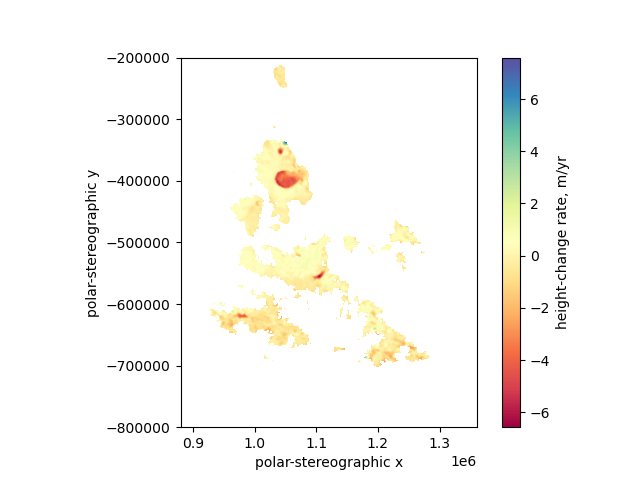

In [72]:
plt.figure(); 
hax=plt.gca()
h_im=hax.imshow(dhdt, cmap='Spectral',  extent=extent)
hax.set_aspect(1)
hax.set_ylim([-0.8e6, -0.2e6])
hax.set_xlabel('polar-stereographic x')
hax.set_ylabel('polar-stereographic y')
plt.colorbar(h_im, label='height-change rate, m/yr');

If you are looking at the map in interactive mode (%matplotlib widget in the first cell) you can use the box-zoom button to zoom in on the edge of the surging glacier, or you can run the next cell to zoom to pre-selected region:

In [ ]:
YR= np.array([-4.2e5, -3.85e5])
XR= np.array([1.015e6, 1.060e6])
hax.plot(XR[[0, 1, 1, 0, 0]], YR[[0, 0, 1, 1, 0]],'k')

plt.figure(); 
ax1=plt.gca()
h_im=ax1.imshow(dhdt, cmap='Spectral',  extent=extent)
ax1.set_aspect(1)
ax1.set_xlim(XR)
ax1.set_ylim(YR)
plt.colorbar(h_im, label='dh/dt, m/yr');

If we want to see the height change for a point, we can find the x and y coordinates that are closest to that point, and plot the delta_h variable for those coordinates.  Let's do that for the point a the center of the current zoomed view, and for another point 12 km to the left:

In [ ]:
# get the limits of the current axes, mark the center
XR=np.array(ax1.get_xlim())  #<----------In interactive mode, try zooming in on a different location
YR=np.array(ax1.get_ylim())
xc=XR.mean()
yc=YR.mean()

# find the point closest to the axes center:
col=np.argmin(np.abs(np.array(ds.x)-xc))
row=np.argmin(np.abs(np.array(ds.y)-yc))
ax1.plot(ds.x[col], ds.y[row],'k*')

plt.figure()
ax2=plt.gca()
ax2.plot(ds.time/365.25+2018, ds.delta_h[:, row, col],'k', marker='*')

# find another point 12 km to the left of the center:
col=np.argmin(np.abs(np.array(ds.x)-(xc-12000)))
row=np.argmin(np.abs(np.array(ds.y)-yc))
ax1.plot(ds.x[col], ds.y[row],'g*')
ax2.plot(ds.time/365.25+2018, ds.delta_h[:, row, col],'g', marker='*')
ax2.set_xlabel('time'); ax2.set_ylabel('height WRT 2020.0, m');

## 3. ATL11 along-track height data

We might be interested to see where these height changes come from.  ATL15 is derived from the ATL11 (along-track height change) product, which maps height changes for individual ICESat-2 reference tracks.  We don't necessarily know what track has contributed to the height change at any given point, so we need to bring in some more data-discovery tools to get there.

### 3.1 Finding ATL11 data using IcePyx and CMR

We can use a CMR (Common Metadata Repository) query through icepyx to find what ATL11 granules have contributed to the height changes we see above.  CMR queries are conducted in latitude and longitude, rather than projected coordinates, so we'll need to find the latitude and longitude for the zoomed-in axes using pyproj:

In [ ]:
# Prepare coordinate transformations between lat/lon and the ATL15 coordinate system
crs=CRS.from_epsg(3413)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lat, corners_lon=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
latlims=[np.min(corners_lat), np.max(corners_lat)]
lonlims=[np.min(corners_lon), np.max(corners_lon)]

We'll use these limits for a CMR query:

In [ ]:
region_a = ipx.Query('ATL11', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-01-01','2022-06-01'], \
                          start_time='00:00:00', end_time='23:59:59')

In [ ]:
region_a.avail_granules()

In [ ]:
for count, granule in enumerate(region_a.granules.avail[0:10]):
    print(f' {count} {granule["producer_granule_id"]}')

There are a total of 55 granules that intersect our region. This is too many files to download during a tutorial, although it's not a huge amount of data.  Let's take a peek at the ATL11 filenames to help decide what to download.  These filenames follow a specific format:

**ATL11_054803_0311_004_01.h5**

This name is made up of :

**ATL11_ttttrr_c0c1_RRR_VV.h5**

where
- ATL11 is the product name
- tttt is the reference ground track (0548)
- rr is the subregion (03 indicates as ascending track in the northern mid latitudes)
- c0c1 are the first and last repeat-track cycles in the granule
- RRR is the release
- VV is the version

The subregion is particularly useful here: region 03 are mid-northern-hemisphere ascending tracks, and region 04 are mid-northern-hemisphere descending tracks.  Region 04 crosses the pole.  Let's start by just downloading region 03.  We'll use the shell program 'wget' to do the downloads, and a regular expression to capture the region number.

In [ ]:
ATL11_re=re.compile('ATL11_(\d\d\d\d)(\d\d)_')

for granule in region_a.granules.avail:
    this_name = granule['producer_granule_id']
    # check if each granule has been downloaded already
    if os.path.isfile('/tmp/'+this_name):
        continue
    # pull out the subregion number, skip subregion 4
    subregion = ATL11_re.search(this_name).group(2)
    if not subregion == '03':
        continue
    print(this_name)
    ! wget {granule['links'][0]['href']} -q
    # move the granule to a temporary directory
    ! mv {granule['producer_granule_id']} /tmp/

Let's see what these files look like.  An easy way to see what is in these granules is to use the 'h5ls' utility:

In [ ]:
! h5ls /tmp/ATL11_054803_0311_004_01.h5

The 'pt1','pt2', and 'pt3' groups contain data for the left, middle and right pair tracks.  It's in these tracks that we find the data:

In [ ]:
! h5ls /tmp/ATL11_054803_0311_004_01.h5/pt2

Here we see 'latitude', 'longitude', 'delta_time', and 'h_corr', which give the location, timing, and height of the data.  

### 3.2 Reading ATL11 data into a dictionary

To look at the data in the ATL11 files, we will use the _h5py_ package.  We'll 
1. Store the data from each file in a dictionary 
2. Store the file-level data in another dictionary

In [ ]:
file_xyth={}
# use the glob package to find the ATL11s that we downloaded
for file in glob.glob('/tmp/ATL11*.h5'):
    with h5py.File(file,'r') as h5f:
        try:
            lat=np.array(h5f['pt2']['latitude'])
            lon=np.array(h5f['pt2']['longitude'])
        except Exception:
            pass
        x,y = to_xy_crs.transform(lat, lon)
        file_xyth[file]={'x':x,'y':y, 'h':np.array(h5f['pt2']['h_corr']), 't':np.array(h5f['pt2']['delta_time'])}
        # read the height values
        temp=np.array(h5f['pt2']['h_corr'])
        # identify invalid heights, and set them to NaN
        temp[temp==h5f['pt2/']['h_corr'].attrs['_FillValue']]=np.NaN
        
        # store the data in a second dictionary:
        file_xyth[file]['h']=temp


### 3.3 Plotting ATL11 measurement locations

In [ ]:
plt.figure(); 
plt.imshow(dhdt, cmap='Spectral', extent=extent)
plt.gca().set_aspect(1)
for filename, D in file_xyth.items():
    plt.plot(D['x'], D['y'],'.', label=filename)

plt.legend(loc='lower left', bbox_to_anchor=[1, 0])
plt.tight_layout()

The granules extend well beyond our region of interest, but if you zoom in on the edge of the surge region, you'll see that they all hit (or come close to hitting) the region we specified.

In [ ]:
# zoomed-in version for rendered tutorial:
plt.figure(); 
plt.imshow(dhdt, cmap='Spectral', extent=extent)
plt.gca().set_aspect(1)
for filename, D in file_xyth.items():
    plt.plot(D['x'], D['y'],'.', label=filename)

plt.gca().set_xlim(XR)
plt.gca().set_ylim(YR)
plt.legend(loc='lower left', bbox_to_anchor=[1, 0])
plt.tight_layout()

### 3.4 Plotting ATL11 heights

Let's find the points that are within our bounding box for one of the files:

In [ ]:
xyth=file_xyth['/tmp/ATL11_054803_0311_004_01.h5']   #<---------- Try a different ATL11 file here!
ind=xyth['x'] > XR[0] 
ind &= xyth['x'] < XR[1]
ind &= xyth['y'] > YR[0]
ind &= xyth['y'] < YR[1]

To get an idea of what's in the file, we'll plot the heights against the projected x coordinate for the data.

In [ ]:
plt.figure(); 
for cycle in range(3, 12):
    # Cycles in the ATL11 run from 3 to 11, so each cycle's data is in the cycle-3rd column
    if np.any(np.isfinite(xyth['h'][ind,cycle-3])):
        plt.plot(xyth['x'][ind], xyth['h'][ind,cycle-3], label=f'cycle={cycle}')
plt.legend()
plt.gca().set_xlabel('polar stereographic x')
plt.gca().set_ylabel('ATL11 height, m');

We can see that on the left-hand side of the ice cap, the height has been constant in time, but the right-hand side of the track samples the region that is thinning rapidly.  Let's find the data for a point in the thinning region and plot it:

In [ ]:
# find the data close to x=1.036e6 
ind_11 = np.argmin(np.abs(xyth['x']-1.036e6)) #<-------------Try a different x location here
plt.figure()
plt.plot(xyth['t'][ind_11,:]/24/3600/365.25 + 2018, xyth['h'][ind_11,:],'.')
plt.gca().set_ylabel('ATL11 height, m')
plt.gca().set_xlabel('year')

plt.tight_layout()

## 4. ATL06 height data

ATL11 data are generated by combining ALT06 data collected over the same ground track, for different cycles.  We can use CMR to identify data from a specific ground track, and we can look at our ATL11 filenames to see what 

Next, let's look at the ATL06 data that were used to generate the ATL11 data.  If we can acquire the ATL06 files for RGT 0548, subregion 03, we'll have the data that went into this ATL11.
### 4.1 Querying CMR for ATL06 on a specific track
Let's try icePyx to query CMR again to look for these data.  We can use the same query as before, but requesting ATL06, and specifying the 'tracks' keyword to obtain only RGT 0548.  Our search box is right on a region boundary, so we'll check the filenames to obtain only region 3.

In [ ]:
region_b = ipx.Query('ATL06', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-01-01','2022-06-01'], \
                          start_time='00:00:00', end_time='23:59:59', tracks=[548])
region_b.avail_granules()

As before, we can download these granules using wget, using a regular expression to check that each file is actually in our region:

In [ ]:

# this regular expression matches the track number, the cycle, and the region 
# in an ATL06 filename
ATL06_re=re.compile('ATL06_\d+_(\d\d\d\d)(\d\d)(\d\d)_')

for granule in region_b.granules.avail:
    this_name=granule['producer_granule_id']
    # skip the granule if we're not in region 03
    if not ATL06_re.search(this_name).group(3) == "03":
        continue
    # check if each granule has been downloaded already
    if os.path.isfile('/tmp/'+this_name):
        continue
    print(this_name)
    ! wget -nc {granule['links'][0]['href']} -q
    ! mv {this_name} /tmp

### 4.2 Structure of an ATL06 granule

And, as before, we can look at the contents of one of these granules using h5ls:

In [ ]:
! h5ls /tmp/ATL06_20191101185115_05480503_005_01.h5

The latitude, longitude, and height data are in the gtxx/land_ice_segments group:

In [ ]:
! h5ls /tmp/ATL06_20191101185115_05480503_005_01.h5/gt2l/land_ice_segments

### 4.3 Reading ATL06 data into a dictionary:

Let's read the data, and store them in a dictionary.  We'll also parse the filename to get the cycle for each file.


In [ ]:
cycle_D6={}

for file in sorted(glob.glob('/tmp/ATL06*.h5')):
    this_D={}
    with h5py.File(file,'r') as h5f:
        for field in ['latitude','longitude','h_li','atl06_quality_summary','ground_track/x_atc']:
            temp=np.array(h5f['gt2r/land_ice_segments'][field])
            try:
                temp[temp==h5f['gt2r/land_ice_segments'][field].attrs['_FillValue']]=np.NaN
            except KeyError:
                pass
            # handle the 'ground_track/x_atc' field
            if '/' in field:
                field=field.split('/')[1]
            this_D[field]=temp
    this_D['x'], this_D['y'] = to_xy_crs.transform(this_D['latitude'],this_D['longitude'])
    cycle_D6[ATL06_re.search(file).group(2)] = this_D



Let's also figure out what points are within our region of interest:

In [ ]:
for cycle, D6 in cycle_D6.items():
    ind = D6['x'] > XR[0] 
    ind &= D6['x'] < XR[1]
    ind &= D6['y'] > YR[0]
    ind &= D6['y'] < YR[1]
    D6['index']=ind

Now let's put these granules on the map, using the subset index we just calculated:

In [ ]:
plt.figure()
plt.imshow(dhdt, cmap='Spectral', extent=extent)
plt.gca().set_aspect(1)
for cycle, D in cycle_D6.items():
    plt.plot(D['x'][D['index']], D['y'][D['index']],'.', label="cycle "+cycle)
plt.gca().set_xlim(XR)
plt.gca().set_ylim(YR)
plt.legend(loc='lower left', bbox_to_anchor=[1, 0])

plt.tight_layout()


If you zoom in, you'll see that there are two cycles (cycle 1 and cycle 2) off by themselves, and the rest are clustered over the RGT. 

### 4.3 Plotting ATL06 data

Let's look at heights. We can plot the surface height (h_li) against the along-track coordinates (x_atc).  

In [ ]:
plt.figure()
for cycle, D6 in cycle_D6.items():
    plt.plot(D6['x_atc'][D6['index']],D6['h_li'][D6['index']],'.', label="cycle "+cycle)

plt.legend(loc='lower left', bbox_to_anchor=[1, 0])

plt.gca().set_xlabel('ATL06 along-track x, m')
plt.gca().set_ylabel('ATL06 height, m')

plt.tight_layout()


This doesn't look promising.  We have lots of height values that look nothing like a glacier, much less an island.  Fortunately, ATL06 comes with a quality flag (atl06_quality_summary) that identifies segments that are likely good (zero means no problems).

In [ ]:
plt.figure()
for cycle, D6 in cycle_D6.items():
    good=D6['index'] & (D6['atl06_quality_summary']==0)
    if np.any(good):
        plt.plot(D6['x_atc'][good],D6['h_li'][good],'.', label="cycle "+cycle)

plt.gca().set_xlabel('ATL06 along-track x, m')
plt.gca().set_ylabel('ATL06 height, m')
        
plt.legend(loc='lower left', bbox_to_anchor=[1, 0])
plt.tight_layout()


Now we can see what we wanted to see.  The data now run from south to north (the opposite orientation from the previous plots), but we can see where the height is changing.  The height-change signal is somewhat obscured because the tracks are not exactly on top of one another, unlike in ATL11, where the across-track slope is taken into account.

## 5. ATL03 data from SlideRule

To go one level deeper, we'll move to a different tool.  The SlideRule project provides ATL03 photon data from a convenient web API.  We'll request data for one cycle, and show the photon heights and classifications.  SlideRule can query specific ATL03 files, and we can determine what ATL03 we want based on the ATL06 filenames we already have.   (SlideRule can also do CMR queries, but for the purposes of this tutorial, it's easiest to choose a specific file).

In [ ]:
from sliderule import icesat2
url="icesat2sliderule.org"
icesat2.init(url, verbose=False)

In [ ]:
granule='ATL06_20190802231121_05480403_005_01.h5'

params= { 'poly':[{'lon':this_lon, 'lat':this_lat} for this_lon, this_lat in zip(corners_lon, corners_lat)],
        'srt':3,
         'cnf':0,
        'len':20, 
         'track':2,
         'pair':0,
         'pass_invalid':True}

temp=icesat2.atl03s(params, granule.replace('ATL06','ATL03'), 
                     asset="nsidc-s3")

The SlideRule atl03s function returns a pandas dataFrame containing photon-level data:

In [ ]:
temp[0:5]

In SlideRule, the nomenclature is a little different from elsewhere in the ICESat-2 project : a 'track' in SlideRule is a 'Pair' elsewhere, and the 'pair' variable distinguishes the left and right beams in an ICESat-2 beam pair.  

### 5.1  Plotting ATL03 photon heights and confidence values:

To plot the data, we'll obtain the along-track location information using the 'segment_dist' and 'distance' fields in the dataframe, and use the 'atl03_cnf' (confidence that the photon is not noise) to color-code each photon:

In [ ]:
temp_p=temp[temp.pair==0]
D6=cycle_D6['04']
plt.figure(); 

colors=['black','gray', 'blue','red','orange']

for q_val, color in zip(np.arange(5), colors):
    these=temp_p['atl03_cnf']==q_val
    plt.plot(temp_p['segment_dist'][these]+temp_p['distance'][these], temp_p.height[these],'.', markersize=0.5)

plt.gca().set_xlabel('along-track x, m')
plt.gca().set_ylabel('ATL03 height, m')

We can also overlay the ATL06 segment heights on the plot:

In [ ]:
plt.figure()

plt.plot(temp_p['segment_dist']+temp_p['distance'], temp_p.height,'.', markersize=0.5)
plt.plot(D6['x_atc'][D6['index']], cycle_D6['04']['h_li'][D6['index']],'r.', markersize=1)

plt.gca().set_xlabel('along-track x, m')
plt.gca().set_ylabel('ATL03/06 height, m');

## Summary

Thanks for following along.  If you look back through the code above, there are a few different places where you can change the regions and the tracks, and see how different data look.  Later on in the hack week you'll see different (better) ways to do some of the tasks that we've done here, but the basic tools (h5py, h5ls, and numpy) are good to have on hand to help debug some of the more advanced techniques.  Happy hacking!